In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.transforms import Lambda

import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

import pickle
from pathlib import Path


Это автоэнкодер, а именно класс датасета, трехслойный сверточный энкодер и симметричный декодер.
С размером входных данных 24*24 получается 36-мерный эмбеддинг.

In [3]:
class EyeDataset(Dataset):
    def __init__(self, img_dir: Path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        self.img_list = list(img_dir.glob('*.jpg'))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        img = read_image(img_path.as_posix())
        if self.transform:
            img = self.transform(img)
        return img
    

In [4]:
class EyeEncoder(nn.Module):
    def __init__(self):
        super(EyeEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, (7, 7), padding='same'),  # 128 x 24 x 24
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2, 2)),                       # 128 x 12 x 12
            nn.Conv2d(128, 32, (3, 3), padding='same'), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)),                       # 32 x 6 x 6
            nn.Conv2d(32, 1, (7, 7), padding='same'),   # 1 x 6 x 6
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    

class EyeDecoder(nn.Module):
    def __init__(self):
        super(EyeDecoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 32, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 128, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 1, (7, 7), padding=(3, 3)),
            nn.Sigmoid()
        )
        
# torch.Size([64, 32, 6, 6])
# torch.Size([64, 32, 6, 6])
# torch.Size([64, 32, 12, 12])
# torch.Size([64, 128, 12, 12])
# torch.Size([64, 128, 12, 12])
# torch.Size([64, 128, 24, 24])
# torch.Size([64, 1, 24, 24])
# torch.Size([64, 1, 24, 24])

    def forward(self, x):
        x = self.decoder(x)
        return x
    
    
class EyeAutoencoder(nn.Module):
    def __init__(self):
        super(EyeAutoencoder, self).__init__()
        self.encoder = EyeEncoder()
        self.decoder = EyeDecoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, x, in enumerate(dataloader):
        x_in = x.to(device)

        x_out = model(x_in)
        loss = loss_fn(x_out, x_in)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

В качестве лосс-функции используется бинарная кросс-энтропия.
Для оптимизации взят Adam с learning rate 10^-3.

In [6]:
def div_by_255(x):
    return x / 255.

img_dir = Path('data')
train_dataset = EyeDataset(img_dir, transform=Lambda(lambda x: div_by_255(x)))
train_dataloader = DataLoader(train_dataset, batch_size=1024)



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = EyeAutoencoder().to(device)
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using cuda device
EyeAutoencoder(
  (encoder): EyeEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=same)
      (9): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): EyeDecoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
      (2): Upsample(sca

In [ ]:
epochs = 150
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

Epoch 1
-------------------------------
loss: 0.691971  [    0/ 3600]
Epoch 2
-------------------------------
loss: 0.643092  [    0/ 3600]
Epoch 3
-------------------------------
loss: 0.636139  [    0/ 3600]
Epoch 4
-------------------------------
loss: 0.632821  [    0/ 3600]
Epoch 5
-------------------------------
loss: 0.629422  [    0/ 3600]
Epoch 6
-------------------------------
loss: 0.626886  [    0/ 3600]
Epoch 7
-------------------------------
loss: 0.625001  [    0/ 3600]
Epoch 8
-------------------------------
loss: 0.623158  [    0/ 3600]
Epoch 9
-------------------------------
loss: 0.621780  [    0/ 3600]
Epoch 10
-------------------------------
loss: 0.620564  [    0/ 3600]
Epoch 11
-------------------------------
loss: 0.619608  [    0/ 3600]
Epoch 12
-------------------------------
loss: 0.618815  [    0/ 3600]
Epoch 13
-------------------------------
loss: 0.618127  [    0/ 3600]
Epoch 14
-------------------------------
loss: 0.617564  [    0/ 3600]
Epoch 15
------

/home/buzin@ad.speechpro.com/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Небольшая визуализация, чтобы убедиться, что автоэнкодер адекватно автоэнкодит:

In [ ]:
img = train_dataset[3]

img_in = img.detach().cpu().numpy()
img_in = (img_in * 255).astype(np.uint8)
img_in = np.transpose(img_in, (1, 2, 0))
plt.imshow(img_in)

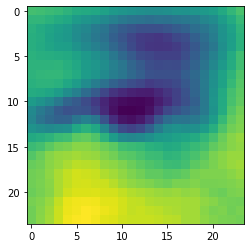

In [8]:
img_out = model(torch.unsqueeze(img, 0).to(device))
img_out = img_out.detach().cpu().squeeze(0).numpy()
img_out = (img_out * 255).astype(np.uint8)
img_out = np.transpose(img_out, (1, 2, 0))
plt.imshow(img_out)

Используем полученный энкодер, чтобы расчитать эмбеддинги для всего train сета:

In [9]:
infer_dataloader = DataLoader(train_dataset, batch_size=128)

embs = []

for x in infer_dataloader:
    x = x.to(device)
    x_emb = model.encoder(x)
    x_emb = torch.flatten(x_emb, start_dim=1)
    embs.append(x_emb.detach().cpu().numpy())
    
embs = np.concatenate(embs, axis=0)
    

Кластеризуем эмбеддинги с помощью kmeans:

In [16]:
clustering = KMeans(init="k-means++", n_clusters=2, n_init=100, random_state=0)
clustering.fit(embs)
labels = clustering.predict(embs)

In [17]:
out_path = Path('train_result.csv')

with out_path.open('w') as f:
    for label, img_path in zip(labels, train_dataset.img_list):
        f.write(f'{img_path},{label}\n')
        

1


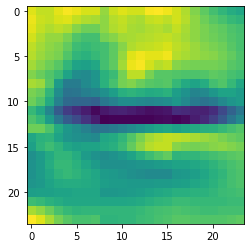

In [18]:
idx = 18

print(labels[idx])

img = train_dataset[idx]
img = img.detach().cpu().numpy()
img = (img * 255).astype(np.uint8)
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

Экспортируем модели и кластеризатор, чтобы использовать их в inference.py

In [ ]:
out_dir = Path('params')
out_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.encoder.state_dict(), out_dir.joinpath(Path('encoder.pth')))
torch.save(model.decoder.state_dict(), out_dir.joinpath(Path('decoder.pth')))

with out_dir.joinpath(Path('clustering.pkl')).open('wb') as f:
    pickle.dump(clustering, f, protocol=pickle.HIGHEST_PROTOCOL)
